## Imports

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re

In [2]:
from dist_ir.ir import Module
from dist_ir.ir import Topology
from dist_ir.ir.type import Float
from dist_ir.ir.type import Tensor
from dist_ir.executor.cost_inference import CostModel
from dist_ir.executor import DistributedSimulator
from dist_ir.transforms import (
    DataParallelTransform,
    PipelineParallelTransform,
    PipeDreamScheduler,
    FIFOScheduler,
)

## Utils

In [3]:
def construct_topology(num_devices, bandwidth):
    topology = Topology()
    for i in range(num_devices):
        topology.add_device("gpu")
    for i in range(num_devices):
        for j in range(i + 1, num_devices):
            topology.set_bandwidth(topology.devices[i], topology.devices[j], bandwidth)
    return topology

In [4]:
def construct_mlp_module(topology, batch_size, num_classes, input_dim, hidden_dims):
    module = Module()

    device = topology.devices[0]
    x = module.add_input_value(
        "x", Tensor(Float(), (batch_size, input_dim), device=device)
    )
    z = module.add_input_value(
        "z", Tensor(Float(), (batch_size, num_classes), device=device)
    )

    weights = []
    weight_grads = []
    activations = []
    activation_grads = []

    for i in range(0, len(hidden_dims) + 1):
        if i == 0:
            dims = (input_dim, hidden_dims[0])
        elif i == len(hidden_dims):
            dims = (hidden_dims[-1], num_classes)
        else:
            dims = (hidden_dims[i - 1], hidden_dims[i])
        weights.append(
            module.add_input_value(
                f"w{i}",
                Tensor(Float(), dims, device=device),
            )
        )

    for i in range(0, len(weights) - 1):
        if i == 0:
            inputs = [x, weights[0]]
        else:
            inputs = [activations[i - 1], weights[i]]
        activations.append(
            module.add_op(
                "MatMul",
                f"MatMul{i}",
                inputs=inputs,
                output_names=[f"a{i}"],
            )
        )
    y = module.add_op(
        "MatMul",
        f"MatMul{i+1}",
        inputs=[activations[-1], weights[-1]],
        output_names=["y"],
    )
    l = module.add_op(
        "Loss", "Loss", inputs=[y, z], attributes={"N": batch_size}, output_names=["l"]
    )
    dl = module.add_op(
        "LossGrad",
        "LossGrad",
        inputs=[y, z],
        attributes={"N": batch_size},
        output_names=["dl"],
    )

    backprop = dl
    for i in range(len(weights) - 1, -1, -1):
        if i > 0:
            a = activations[i - 1]
        else:
            a = x
        w = weights[i]
        da, dw = module.add_op(
            "MatMulGrad",
            f"MatMul{i}Grad",
            inputs=[a, w, backprop],
            output_names=[f"d{a.name}", f"d{w.name}"],
        )
        activation_grads.append(da)
        weight_grads.append(dw)
        backprop = da

    module.set_outputs(weight_grads)
    module.finalize()
    return module

## Data parallel results

In [5]:
def simulate_data_parallel(
    num_workers,
    batch_size=16,
    input_dim=4,
    hidden_dims=[2],
    num_classes=10,
    bandwidth=2,
    device_speeds={"gpu": 1.0e13}
):
    topology = construct_topology(num_workers, bandwidth)
    module = construct_mlp_module(
        topology, batch_size, num_classes, input_dim, hidden_dims
    )
    transform = DataParallelTransform(
        batch_dims={"x": 0, "z": 0},
        reduction_params={
            f"{dw.name}": {"op_type": "Allreduce"} for dw in module.get_outputs()
        },
        devices=topology.devices,
    )
    transformed_module = transform.apply(module)
    transformed_module.finalize()
    cost_model = CostModel(topology, device_speeds)
    simulator = DistributedSimulator(cost_model)
    simulator_state = simulator.simulate(transformed_module)
    return simulator_state

In [6]:
def run_data_parallel_experiment(
    all_num_workers,
    batch_size,
    input_dim,
    hidden_dims,
    num_classes,
    bandwidth,
    device_speeds,
):
    all_simulator_states = []
    for num_workers in all_num_workers:
        all_simulator_states.append(
            simulate_data_parallel(
                num_workers,
                batch_size,
                input_dim,
                hidden_dims,
                num_classes,
                bandwidth,
                device_speeds,
            )
        )
    return all_simulator_states

In [7]:
def get_data_parallel_data(all_num_workers, all_batch_sizes):
    input_dim = 32
    hidden_dims = [64, 128, 256, 512, 1024]
    num_classes = 10
    bandwidth = 100.0
    device_speeds = {"gpu": 1.0e13}
    results = {
        batch_size: run_data_parallel_experiment(
            all_num_workers,
            batch_size,
            input_dim,
            hidden_dims,
            num_classes,
            bandwidth,
            device_speeds,
        )
        for batch_size in all_batch_sizes
    }
    return results

In [8]:
def plot_data_parallel_runtime(all_num_workers, all_batch_sizes, results, offset=3):
    c = np.arange(1, len(all_batch_sizes) + offset)
    norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
    cmap.set_array([])
    frame = plt.gca()
    for i, batch_size in enumerate(all_batch_sizes):
        execution_times = [
            max([s.timestamps[d] for d in s.timestamps]) for s in results[batch_size]
        ]
        plt.plot(
            all_num_workers,
            execution_times,
            marker="o",
            label=f"Batch size {batch_size}",
            c=cmap.to_rgba(i + offset)
        )
    plt.legend()
    plt.xlabel("# Workers\n(log scale)")
    plt.ylabel("Simulated execution time")
    plt.xscale("log")
    _ = plt.xticks(all_num_workers)
    _ = frame.axes.xaxis.set_ticklabels(all_num_workers)
    _ = frame.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig("figures/data_parallel_results.png", dpi=300)

In [9]:
all_num_workers = [1, 2, 4, 8, 16, 32, 64, 128, 256]
all_batch_sizes = [128, 256, 512, 1024]
data_parallel_results = get_data_parallel_data(all_num_workers, all_batch_sizes)

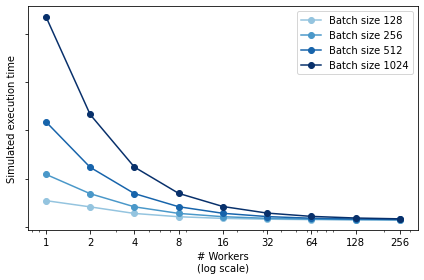

In [10]:
plot_data_parallel_runtime(all_num_workers, all_batch_sizes, data_parallel_results, offset=3)

## Pipeline parallel results

In [11]:
def simulate_pipeline_parallel(
    scheduler_type,
    num_microbatches=2,
    num_devices=2,
    batch_size=16,
    input_dim=4,
    hidden_dims=[2],
    num_classes=10,
    bandwidth=2,
    device_speeds={"gpu": 1.0e13},
    verbose=False
):
    if scheduler_type == "pipedream":
        scheduler = PipeDreamScheduler(num_microbatches)
    elif scheduler_type == "fifo":
        scheduler = FIFOScheduler(num_microbatches)
    topology = construct_topology(num_devices, bandwidth)
    module = construct_mlp_module(
        topology, batch_size, num_classes, input_dim, hidden_dims
    )
    num_devices = len(topology.devices)
    num_layers = len(hidden_dims) + 1
    layers_per_device = num_layers // num_devices
    partition_map = {}
    for op_name in module.get_ops():
        is_loss = "Loss" in op_name
        if not is_loss:
            assert "MatMul" in op_name
            match = re.search("MatMul(\d+)", op_name)
            layer_num = int(match.group(1))
            device = topology.devices[int(np.floor(layer_num / layers_per_device))]
        else:
            device = topology.devices[
                int(np.floor(len(hidden_dims) / layers_per_device))
            ]
        partition_map[op_name] = device
    schedule=scheduler.schedule(module, partition_map)
    if verbose:
        for i in range(len(schedule)):
            print(i, schedule[i])
    transform = PipelineParallelTransform(
        num_microbatches=num_microbatches,
        batch_dims={"x": 0, "z": 0},
        reduction_params={
            f"{dw.name}": {"op_type": "Add"} for dw in module.get_outputs()
        },
        schedule=schedule,
    )
    transformed_module = transform.apply(module)
    transformed_module.finalize()
    cost_model = CostModel(topology, device_speeds)
    simulator = DistributedSimulator(cost_model)
    simulator_state = simulator.simulate(transformed_module)
    return simulator_state

In [12]:
def run_pipeline_parallel_experiment(num_microbatches, num_devices):
    batch_size = 1024
    input_dim = 32
    hidden_dims = [128] * 15
    num_classes = 10
    bandwidth = float("inf")
    device_speeds = {"gpu": 1.0e13}
    pipedream_state = simulate_pipeline_parallel(
        "pipedream",
        num_microbatches=num_microbatches,
        batch_size=batch_size,
        num_devices=num_devices,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        bandwidth=bandwidth,
        device_speeds=device_speeds,
    )
    fifo_state = simulate_pipeline_parallel(
        "fifo",
        num_microbatches=num_microbatches,
        batch_size=batch_size,
        num_devices=num_devices,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        bandwidth=bandwidth,
        device_speeds=device_speeds,
    )
    fifo_execution_time = max([fifo_state.timestamps[d] for d in fifo_state.timestamps])
    pipedream_execution_time = max([pipedream_state.timestamps[d] for d in pipedream_state.timestamps])
    speedup = fifo_execution_time / pipedream_execution_time
    return speedup

In [13]:
all_num_devices = [1, 2, 4, 8]
all_num_microbatches = [2, 4, 8, 16, 32]
pipeline_parallel_results = np.ones((len(all_num_devices), len(all_num_microbatches)))
for i, num_devices in enumerate(all_num_devices):
    for j, num_microbatches in enumerate(all_num_microbatches):
        pipeline_parallel_results[i][j] = run_pipeline_parallel_experiment(num_microbatches, num_devices)

In [14]:
def plot_pipeline_parallel_heatmap(all_num_devices, all_num_microbatches, pipeline_parallel_results):
    fig, ax = plt.subplots()
    im = ax.imshow(pipeline_parallel_results[1:], cmap="RdYlGn")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(all_num_microbatches)))
    ax.set_yticks(np.arange(len(all_num_devices[1:])))
    # ... and label them with the respective list entries
    ax.set_xticklabels(all_num_microbatches)
    ax.set_yticklabels(all_num_devices[1:])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(all_num_devices[1:])):
        for j in range(len(all_num_microbatches)):
            text = ax.text(j, i, np.round(pipeline_parallel_results[i+1, j], 2),
                           ha="center", va="center", color="black", fontsize=16)

    plt.ylabel("# Devices")
    plt.xlabel("# Microbatches")
    fig.tight_layout()
    plt.savefig("figures/pipeline_parallel_results.png", dpi=300)
    plt.show()

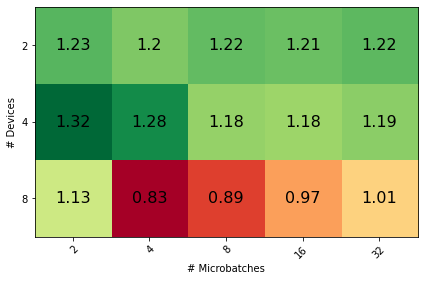

In [15]:
plot_pipeline_parallel_heatmap(all_num_devices, all_num_microbatches, pipeline_parallel_results)

### 4 devices, 2 microbatches

In [16]:
batch_size = 1024
input_dim = 32
hidden_dims = [128] * 15
num_classes = 10
bandwidth = float("inf")
device_speeds = {"gpu": 1.0e13}
pipedream_state = simulate_pipeline_parallel(
        "pipedream",
        num_microbatches=2,
        batch_size=batch_size,
        num_devices=4,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        bandwidth=bandwidth,
        device_speeds=device_speeds,
    )
pipedream_state.dump_chrome_trace("pipedream_4x2_trace.json")
fifo_state = simulate_pipeline_parallel(
        "fifo",
        num_microbatches=2,
        batch_size=batch_size,
        num_devices=4,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        bandwidth=bandwidth,
        device_speeds=device_speeds,
    )
fifo_state.dump_chrome_trace("fifo_4x2_trace.json")

### 8 devices, 4 microbatches

In [17]:
batch_size = 1024
input_dim = 32
hidden_dims = [128] * 15
num_classes = 10
bandwidth = float("inf")
device_speeds = {"gpu": 1.0e13}
pipedream_state = simulate_pipeline_parallel(
        "pipedream",
        num_microbatches=4,
        batch_size=batch_size,
        num_devices=8,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        bandwidth=bandwidth,
        device_speeds=device_speeds,
    )
pipedream_state.dump_chrome_trace("pipedream_8x4_trace.json")
fifo_state = simulate_pipeline_parallel(
        "fifo",
        num_microbatches=4,
        batch_size=batch_size,
        num_devices=8,
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        bandwidth=bandwidth,
        device_speeds=device_speeds,
    )
fifo_state.dump_chrome_trace("fifo_8x4_trace.json")